<a href="https://colab.research.google.com/github/AndrewSpiro/CVQC/blob/main/QML_Finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
from google.colab import files
uploaded = files.upload()

Saving AAPL max.csv to AAPL max (1).csv


In [99]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [100]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
!pip install pennylane

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy import signal
from sklearn import metrics
import pennylane as qml
from pennylane import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import numpy

In [258]:
apple = pd.read_csv("AAPL max.csv", usecols=["Close", "Date"])
apple

,Date,Close
0,1980-12-12,0.128348
1,1980-12-15,0.121652
2,1980-12-16,0.112723
3,1980-12-17,0.115513
4,1980-12-18,0.118862
...,...,...
10712,2023-06-09,180.960007
10713,2023-06-12,183.789993
10714,2023-06-13,183.309998
10715,2023-06-14,183.949997


[[1.28348000e-01]
 [1.21652000e-01]
 [1.12723000e-01]
 ...
 [1.83309998e+02]
 [1.83949997e+02]
 [1.86009995e+02]]


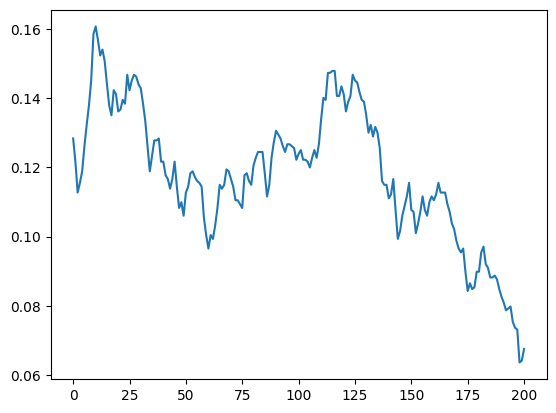

In [259]:
apl = pd.read_csv("AAPL max.csv", usecols = ["Close"])
apl = pd.DataFrame.to_numpy(apl)
np.concatenate(apl)
#aapl = apl[:10080]  # Limiting dataset to what was used in the paper.
sample_size = 201
aapl = apl[:sample_size]  # A small sample to play around with
print(apl)
plt.plot(aapl)

<function matplotlib.pyplot.show(close=None, block=None)>

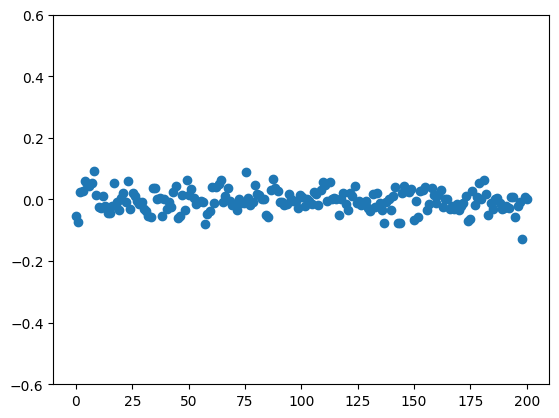

In [260]:
N = sample_size -1
pc = np.zeros((N,1))
for i in range(N-1):
  pc[i] = (aapl[i+1]-aapl[i])/aapl[i]

plt.scatter(np.linspace(0,N,N),pc)
plt.ylim(-0.6,0.6)
plt.show

In [261]:
print(len(pc))

200


In [262]:
P = np.zeros((N//2,1))
nu = np.zeros((N//2,1))
for k in tqdm(range(N//2)):
    sum = 0
    for i in range(N):
        sum += (pc[i] * np.exp(2 * np.pi * i * k * 1j * 1/N))
    P[k] = np.abs(sum)**2
    nu[k] = k/N

100%|██████████| 100/100 [00:01<00:00, 76.63it/s]


[[1.25518002]
 [1.09236469]
 [1.17578809]]
[tensor([0.07], requires_grad=True), tensor([0.085], requires_grad=True), tensor([0.155], requires_grad=True)]


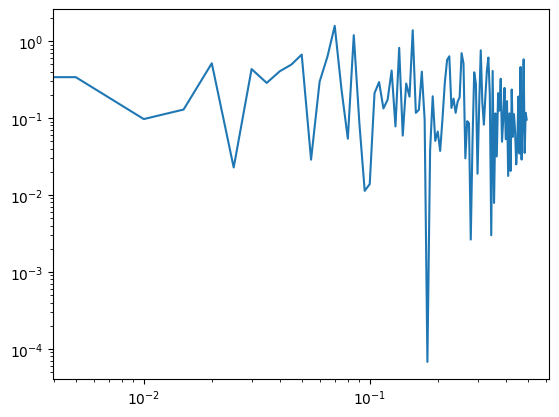

In [263]:
threshold = 1
plt.loglog(nu, P)

amp2 = []
DC = []
for i in range(N//2):
    if P[i] > threshold:
      amp2.append(P[i])
      DC.append(nu[i])
amp = np.sqrt(amp2)
print(amp)
print(DC)

In [264]:
a = np.array([[1,2,3,4],[5,6,7,8]])
a.reshape((2,4,1))

tensor([[[1],
         [2],
         [3],
         [4]],

        [[5],
         [6],
         [7],
         [8]]], requires_grad=True)

In [265]:
c_n = [0, 0.2, 0.5, 0.8, 1]
noise = np.random.uniform(0,1,N) * (c_n[0])
noise = noise.reshape((N,1))
trend = np.array([np.zeros(N), 5e-2 * np.linspace(0,N,N), 2* 5e-5 * np.square(np.linspace(0,N,N))])
trend = trend.reshape(3,N,1)

In [266]:
a = np.zeros((5,2))
a = np.sum(a, axis = -1)
a =a.reshape(5,1)
a

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], requires_grad=True)

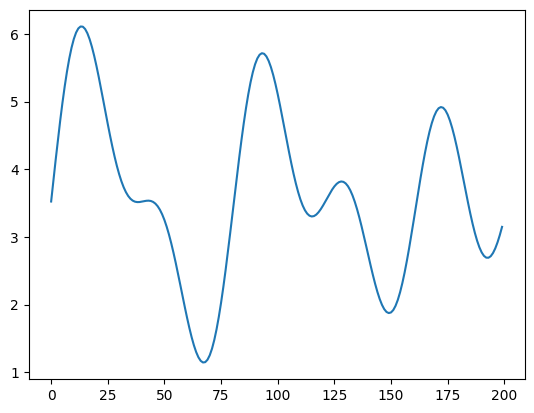

In [267]:
num_components = len(DC)
DC_sample = DC[0:num_components]
amp_sample = amp[0:num_components]
interval = (np.linspace(0,N,N)).reshape((N,1))
components = np.zeros((N,num_components))
for i in range(N):
    for j in range(num_components):
        components[i][j] = amp_sample[j] + np.sin(DC_sample[j] * interval[i])
DC_signal = np.sum(components, axis = -1)
DC_signal = DC_signal.reshape(N,1)
full_signal = DC_signal + noise + trend[0]
plt.plot(range(N),full_signal)

In [278]:
r = num_components
#r = 16  # Following the paper
N_QUBITS = (r + 1)
print(N_QUBITS)
n_layers = 2

dev = qml.device('default.qubit', wires= N_QUBITS)

def block(weights):
    for i in range(1,N_QUBITS):
        qml.IsingXX(weights[0][i-1], wires=[0, i])  # Are the qubits in the right place?
    for i in range(1,N_QUBITS):
        qml.IsingZZ(weights[1][i-1], wires=[0, i])
    for i in range(1,N_QUBITS):
        qml.IsingYY(weights[2][i-1], wires=[0, i])

@qml.qnode(dev, interface="autograd")
def PQC(weights,x):
    qml.AngleEmbedding(x,wires=range(N_QUBITS)[1:])   # Features x are embedded in rotation angles
    for j in range(n_layers):
      block(weights[j])
    return qml.expval(qml.PauliZ(wires=0))

weights = 2 * np.pi * np.random.random(size=(n_layers, 3, r), requires_grad=True)
x = 2 * np.pi *np.random.random(size = (r))

PQC(weights, x)

4


tensor(0.26816914, requires_grad=True)

In [289]:
train = full_signal[:int(N*2/3)]
test = full_signal[int(N*2/3):]

train_size = (len(train)//N_QUBITS) * N_QUBITS
test_size = (len(test)//N_QUBITS) * N_QUBITS

train = train[:train_size]
test = test[:test_size]

scaler = MinMaxScaler((0.2,0.8))
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

grouped_train = scaled_train.reshape(train_size//N_QUBITS, N_QUBITS)
grouped_test = scaled_test.reshape(test_size//N_QUBITS, N_QUBITS)
print(grouped_train)
print(np.zeros(5))
print(grouped_test)

final_train = grouped_train
final_test = grouped_test

[[0.48744154 0.52499089 0.56196903 0.5978165 ]
 [0.63199706 0.66400866 0.69339359 0.71974757]
 [0.74272773 0.76205904 0.77753927 0.78904229]
 [0.79651957 0.8        0.79958789 0.79545935]
 [0.787857   0.77708327 0.76349241 0.74748135]
 [0.72947973 0.70993933 0.68932302 0.66809374]
 [0.64670352 0.62558304 0.60513176 0.585709  ]
 [0.56762621 0.55114038 0.53644907 0.52368692]
 [0.5129238  0.50416467 0.49735106 0.49236427]
 [0.48902999 0.4871244  0.48638149 0.4865015 ]
 [0.48716011 0.48801831 0.48873262 0.48896537]
 [0.48839486 0.48672506 0.48369467 0.47908525]
 [0.47272827 0.46451085 0.45438004 0.44234563]
 [0.42848119 0.41292358 0.39587073 0.37757783]
 [0.35835196 0.33854539 0.31854758 0.29877613]
 [0.27966694 0.26166376 0.24520733 0.23072459]
 [0.2186179  0.20925487 0.20295878 0.2       ]
 [0.20058854 0.20486791 0.21291058 0.2247149 ]
 [0.24020385 0.25922547 0.28155499 0.30689878]
 [0.33489975 0.36514437 0.39717093 0.43047903]
 [0.46453992 0.49880757 0.53273015 0.56576167]
 [0.59737356 

In [280]:
print(grouped_train.shape)
print(final_train.shape)
print(grouped_test.shape)
print(final_test.shape)
print(train_size//N_QUBITS)

(33, 4)
(33, 4)
(16, 4)
(16, 4)
33


In [271]:
#train = full_signal[:int(N*2/3)]
#test = full_signal[int(N*2/3):]
#
#train_size = (len(train)//N_QUBITS) * N_QUBITS
#test_size = (len(test)//N_QUBITS) * N_QUBITS
#
#train = train[:train_size]
#test = test[:test_size]
#
#grouped_train = train.reshape(train_size//N_QUBITS, N_QUBITS)
#grouped_test = test.reshape(test_size//N_QUBITS, N_QUBITS)
#
#scaler = MinMaxScaler((0.2,0.8))
#scaler.fit(train)
#scaled_train = scaler.transform(train)
#scaled_test = scaler.transform(test)
#
#final_train = scaled_train
#final_test_ = scaled_test

In [290]:
def square_loss(targets, predictions):
    loss = 0
    for t, p in zip(targets, predictions):
        loss += (t - p) ** 2
    loss = loss / len(targets)

    return 0.5*loss

def cost(weights, x, y):
    predictions = [PQC(weights, x_) for x_ in x]
    return square_loss(y, predictions)

In [291]:
x = np.zeros((train_size//N_QUBITS, r))
target_y = np.zeros((train_size//N_QUBITS,1))
for i in range(train_size//N_QUBITS):
  x[i] = final_train[i][:-1]
  target_y[i] = final_train[i][-1]

In [293]:
max_steps = 10
opt = qml.AdamOptimizer(.1)
batch_size = train_size//max_steps
cst = [cost(weights, x, target_y)]  # initial cost

In [294]:
epochs = 10

for i in tqdm(range(epochs)):
  for step in range(max_steps):
      # Select batch of data
      batch_index = numpy.random.randint(0, max_steps, batch_size)
      x_batch = x[batch_index]
      y_batch = target_y[batch_index]
      # Update the weights by one optimizer step
      weights,_,_ = opt.step(cost, weights, x_batch, y_batch)  # Calculating weights using the batches.
      c = cost(weights, x, target_y)  # Calculating the cost using the whole train data
      cst.append(c)

100%|██████████| 10/10 [01:42<00:00, 10.29s/it]


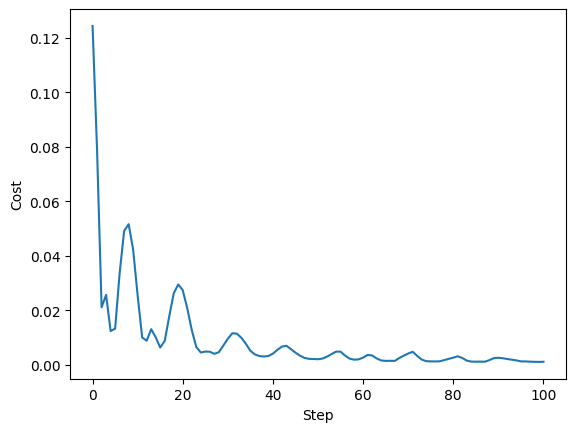

In [295]:
plt.plot(range(len(cst)), cst)
plt.ylabel("Cost")
plt.xlabel("Step")
plt.show();

In [296]:
print(cst[0], (cst[-1]))

[0.12431051] [0.00115156]


In [305]:
from pennylane.pauli.conversion import Y
x_t = np.zeros((test_size//N_QUBITS, r))  # Already grouped and scaled
target_y_t = np.zeros((test_size//N_QUBITS,1))
for i in range(test_size//N_QUBITS):
  x_t[i] = final_test[i][:-1]
  target_y_t[i] = final_test[i][-1]

y_index = []
for i in range(int(N*2/3)+N_QUBITS,N,N_QUBITS):
    y_index.append(i)
y_index = np.array(y_index)
y_index.reshape(16,1)

t_predictions = np.zeros((test_size//N_QUBITS,1))
for i in range(test_size//N_QUBITS):
  t_predictions[i] = (PQC(weights, x_t[i]))
t_predictions = t_predictions.reshape((test_size//N_QUBITS, 1))

In [302]:
metrics.mean_squared_error(t_predictions,target_y_t)

0.0018253858973802115

In [306]:
real_predictions = scaler.inverse_transform(t_predictions)
print(real_predictions)

[[3.60073647]
 [3.19676248]
 [2.77408829]
 [2.49047696]
 [2.42481382]
 [2.6102453 ]
 [3.06786471]
 [3.72589906]
 [4.36754381]
 [4.75431338]
 [4.76648095]
 [4.42399521]
 [3.87321167]
 [3.34272531]
 [3.02077543]
 [2.98033927]]


16
16


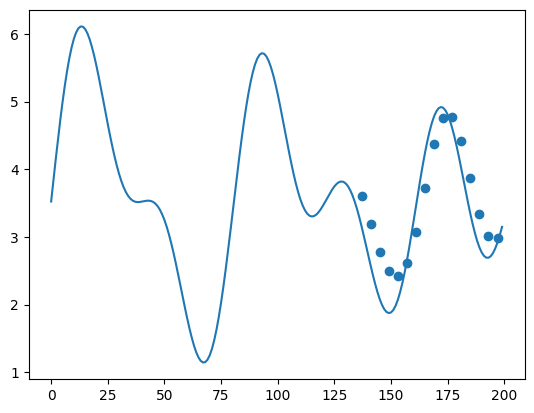

In [307]:
plt.plot(full_signal)
print(len(x_t))
print(len(t_predictions))
plt.scatter(y_index,real_predictions)